## Project: Time Series Analysis on temperature 1985-2022

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")


# Import the relevant sklearn packages
from statsmodels.api import OLS, add_constant
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

# Set figure size to (14,6)
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = '14'

import warnings
warnings.filterwarnings(action='ignore')

# Load and clean the data

In [52]:
df= pd.read_csv('TG_STAID002759.csv',sep=',',skiprows=19, parse_dates=True, index_col=1, skipinitialspace=True)
df

,SOUID,TG,Q_TG
DATE,,,
1876-01-01,127488,22,0
1876-01-02,127488,25,0
1876-01-03,127488,3,0
1876-01-04,127488,-58,0
1876-01-05,127488,-98,0
...,...,...,...
2022-12-27,111448,42,0
2022-12-28,111448,63,0
2022-12-29,111448,100,0


In [54]:
df[df.Q_TG==9]

,SOUID,TG,Q_TG
DATE,,,
1945-04-25,127488,-9999,9
1945-04-26,127488,-9999,9
1945-04-27,127488,-9999,9
1945-04-28,127488,-9999,9
1945-04-29,127488,-9999,9
...,...,...,...
1945-11-01,127488,-9999,9
1945-11-02,127488,-9999,9
1945-11-03,127488,-9999,9


In [55]:
df = df.drop(['SOUID', 'Q_TG'], axis=1)
df = df.rename(columns={'TG': 'mean_temp'})
df.loc[:] *=0.1
df

,mean_temp
DATE,
1876-01-01,2.2
1876-01-02,2.5
1876-01-03,0.3
1876-01-04,-5.8
1876-01-05,-9.8
...,...
2022-12-27,4.2
2022-12-28,6.3
2022-12-29,10.0


In [56]:
# select rows within the date range '2021-01-01' to '2022-12-31'
start_date = '1985-01-01'
end_date = '2022-12-31'
df = df.loc[start_date:end_date]
df

,mean_temp
DATE,
1985-01-01,-3.2
1985-01-02,-4.2
1985-01-03,-6.3
1985-01-04,-7.2
1985-01-05,-10.1
...,...
2022-12-27,4.2
2022-12-28,6.3
2022-12-29,10.0


In [57]:
df.mean_temp==-9

DATE
1985-01-01    False
1985-01-02    False
1985-01-03    False
1985-01-04    False
1985-01-05    False
              ...  
2022-12-27    False
2022-12-28    False
2022-12-29    False
2022-12-30    False
2022-12-31    False
Name: mean_temp, Length: 13879, dtype: bool

# Plot the data

In [58]:
def plot_meantemp(df, title='Daily mean temperature since 1985', ylim=True):
    '''
    Custom plotting function for plotting the meantemp dataset
    
    Parameters
    ----------
    df : pd.DataFrame
        The data to plot.
    title : str
        The title of the plot
    ylim : bool
        Whether to fix the minimum value of y; defalut is True
    
    Returns
    -------
    Plots the data
    '''
    df.plot()
    plt.title(title)
    plt.ylabel('Mean temperature in C')
    if ylim:
        plt.ylim(ymin=0)
    plt.show()

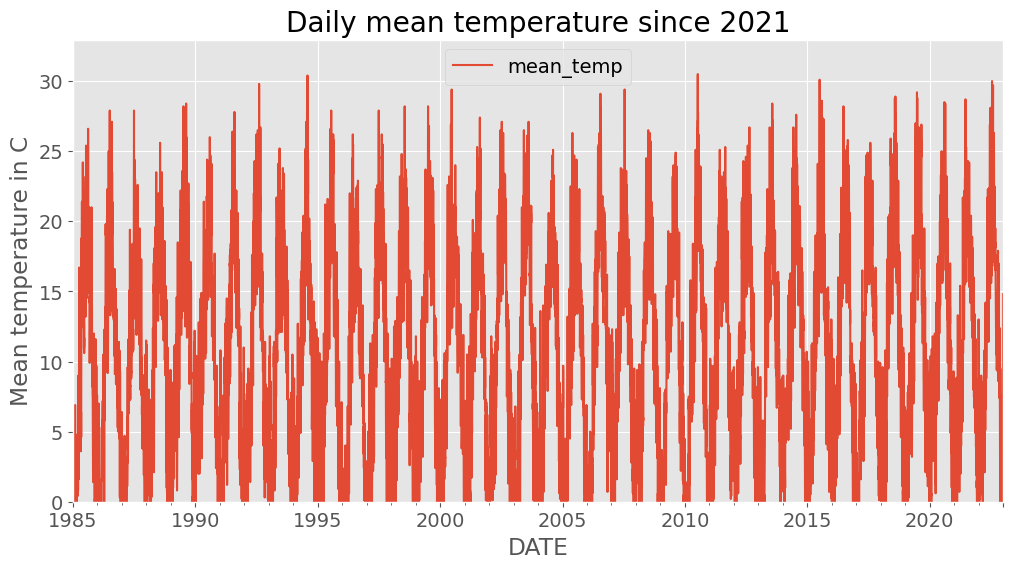

In [59]:
plot_meantemp(df)

# Extract timesteps, seasonal dummies for the whole dataset

In [60]:
# Add timestep feature - for modeling trend
df['timestep'] = range(len(df))
df.head()

,mean_temp,timestep
DATE,,
1985-01-01,-3.2,0
1985-01-02,-4.2,1
1985-01-03,-6.3,2
1985-01-04,-7.2,3
1985-01-05,-10.1,4


In [61]:
# Add seasonal dummies features — for modeling seasonality
seasonal_dummies = pd.get_dummies(
    df.index.day, 
    prefix='day',
    drop_first=True).set_index(df.index)
df = df.join(seasonal_dummies)

#Apply it, when a train/test split is not nessessary
seasonal_dummies = pd.get_dummies(
    df.index.month, 
    prefix='month', 
    drop_first=True).set_index(df.index)


df = df.join(seasonal_dummies)
df.head()


,mean_temp,timestep,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
DATE,,,,,,,,,,,,,,,,,,,,,
1985-01-01,-3.2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1985-01-02,-4.2,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1985-01-03,-6.3,2,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1985-01-04,-7.2,3,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1985-01-05,-10.1,4,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Linear Regression

In [62]:
X=df.drop('mean_temp',axis=1)
y=df['mean_temp']

In [63]:
# Run linear regression to get trend-seasonal component
m = LinearRegression()
m.fit(X, y)

LinearRegression()

In [64]:
# Add trend-seasonal component to the data
df['trend_seasonal'] = m.predict(X)
df.head(2)

,mean_temp,timestep,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,...,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal
DATE,,,,,,,,,,,,,,,,,,,,,
1985-01-01,-3.2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.039823
1985-01-02,-4.2,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.047937


# Plot the original data and preliminary model

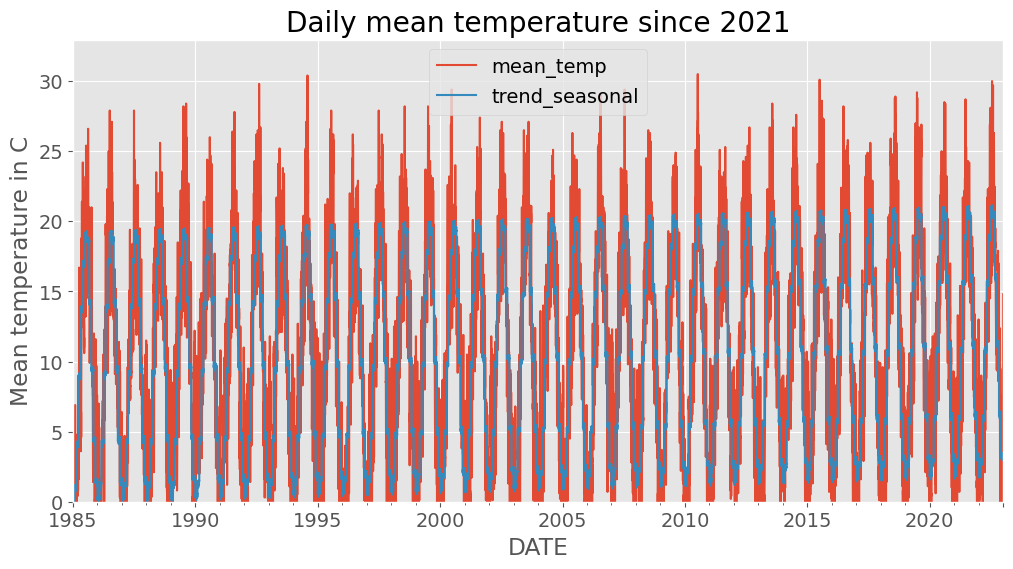

In [65]:
plot_meantemp(df[['mean_temp', 'trend_seasonal']]) #u can see that this model includes both trend as well as seasonality

# Extract the remainder

In [66]:
# Add remainder column (We want to extract the part of the model that the trend_seasonal is not able to explain)
df['remainder'] = df['mean_temp'] - df['trend_seasonal']

In [67]:
from statsmodels.tsa.ar_model import ar_select_order
lags_order = ar_select_order(df['remainder'], maxlag=5)
lags_order.ar_lags



[1, 2, 3]

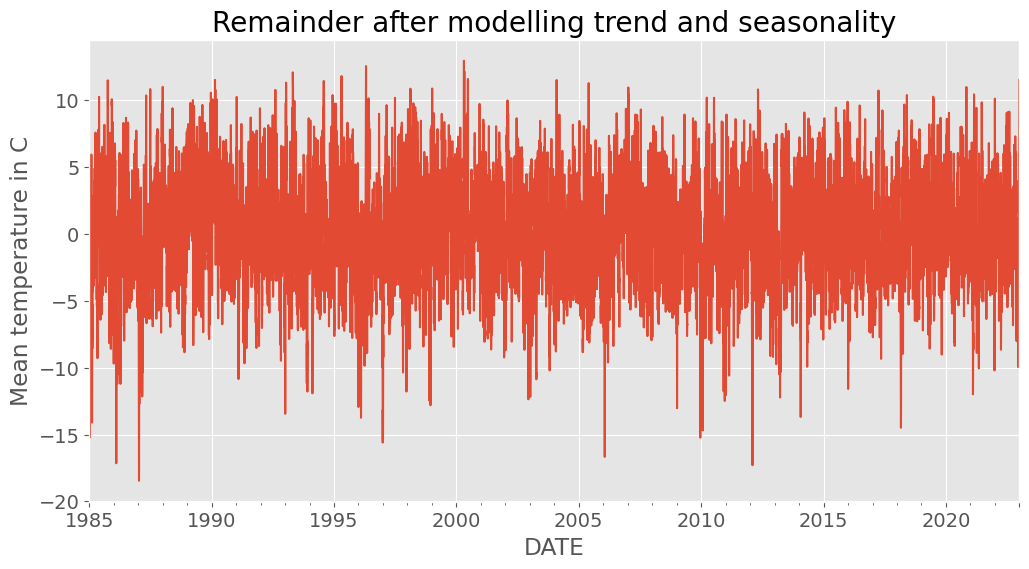

In [68]:
plot_meantemp(df['remainder'], 
             title='Remainder after modelling trend and seasonality', 
             ylim=False)

# Inspect the remainder to decide how many lags to include

Refer to PACF plot from 21.02.23 (we had one lag).

# Add the lags of the remainder to the training data

In [69]:
# Add lag feature — for modeling remainder
df['lag1'] = df['remainder'].shift(1)
df['lag2'] = df['remainder'].shift(2)

df.head(2)

,mean_temp,timestep,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,...,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal,remainder,lag1,lag2
DATE,,,,,,,,,,,,,,,,,,,,,
1985-01-01,-3.2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.039823,-3.239823,NaN,NaN
1985-01-02,-4.2,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.047937,-4.247937,-3.239823,NaN


In [70]:
df.dropna(inplace=True)
df.head(2)

,mean_temp,timestep,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,...,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal,remainder,lag1,lag2
DATE,,,,,,,,,,,,,,,,,,,,,
1985-01-03,-6.3,2,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.248157,-6.548157,-4.247937,-3.239823
1985-01-04,-7.2,3,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0.246622,-7.446622,-6.548157,-4.247937


# Run the full model

In [71]:
# Define X and y for **FULL MODEL**
X_full = df.drop(['mean_temp', 'trend_seasonal', 'remainder'], axis=1)
y_full = df['mean_temp']

...Feature engineering CHECK - next step: Fit the model and make predictions

In [72]:
X_full

,timestep,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,day_10,...,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1,lag2
DATE,,,,,,,,,,,,,,,,,,,,,
1985-01-03,2,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-4.247937,-3.239823
1985-01-04,3,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-6.548157,-4.247937
1985-01-05,4,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-7.446622,-6.548157
1985-01-06,5,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,-10.320087,-7.446622
1985-01-07,6,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,-12.834999,-10.320087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,13874,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,6.044977,1.546292
2022-12-28,13875,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0.787740,6.044977
2022-12-29,13876,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,2.810327,0.787740


In [73]:
m_full = LinearRegression()
m_full.fit(X_full, y_full)

LinearRegression()

In [74]:
# Create a new predictions column
df['predictions_full_model'] = m_full.predict(X_full)
df.tail()

,mean_temp,timestep,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,...,month_8,month_9,month_10,month_11,month_12,trend_seasonal,remainder,lag1,lag2,predictions_full_model
DATE,,,,,,,,,,,,,,,,,,,,,
2022-12-27,4.2,13874,0,0,0,0,0,0,0,0,...,0,0,0,0,1,3.412260,0.787740,6.044977,1.546292,8.882117
2022-12-28,6.3,13875,0,0,0,0,0,0,0,0,...,0,0,0,0,1,3.489673,2.810327,0.787740,6.044977,3.346427
2022-12-29,10.0,13876,0,0,0,0,0,0,0,0,...,0,0,0,0,1,3.334965,6.665035,2.810327,0.787740,5.942142
2022-12-30,7.6,13877,0,0,0,0,0,0,0,0,...,0,0,0,0,1,3.178683,4.421317,6.665035,2.810327,9.069916
2022-12-31,14.8,13878,0,0,0,0,0,0,0,0,...,0,0,0,0,1,3.277958,11.522042,4.421317,6.665035,6.393425


Hint: Timestep, monthly dummies and the lag of the remainder give us the **predictions for the actual data** (not just the remainder).

# Plot the prediction vs mean temperature for the training data

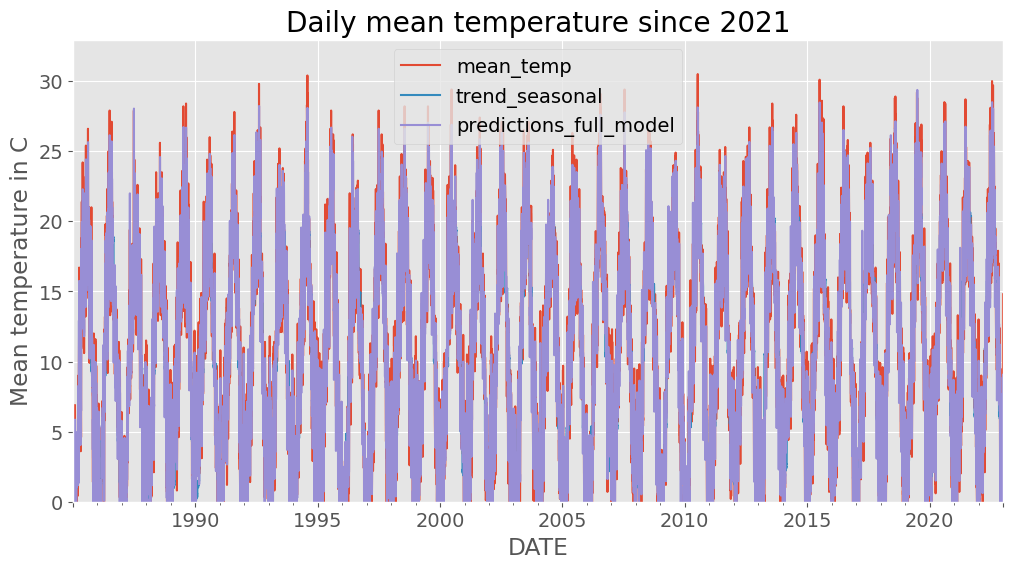

In [75]:
plot_meantemp(df[['mean_temp', 'trend_seasonal', 'predictions_full_model']])
# we started to use the remainder on top of the trend and the seasonal => it seems to fit better

Coefficients of the AR equation's terms:

In [76]:
pd.DataFrame(m_full.coef_.reshape(1,44), columns=X_full.columns)

,timestep,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,day_10,...,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1,lag2
0,0.000136,0.048449,0.236477,0.234806,0.208135,0.222911,0.312029,0.270007,0.195528,0.236182,...,13.562398,16.85175,18.86109,18.369248,13.956269,9.20605,4.146811,1.263247,0.935556,-0.154415


## Evaluate the model

Goal: We want to understand how good our model would work on data it has not been trained on. We can get an estimate of that by using cross-validation.

In [77]:
X_full

,timestep,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,day_10,...,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1,lag2
DATE,,,,,,,,,,,,,,,,,,,,,
1985-01-03,2,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-4.247937,-3.239823
1985-01-04,3,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-6.548157,-4.247937
1985-01-05,4,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-7.446622,-6.548157
1985-01-06,5,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,-10.320087,-7.446622
1985-01-07,6,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,-12.834999,-10.320087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,13874,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,6.044977,1.546292
2022-12-28,13875,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0.787740,6.044977
2022-12-29,13876,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,2.810327,0.787740


In [78]:
# Create a TimeSeriesSplit object
ts_split = TimeSeriesSplit(n_splits=5)

In [79]:
for i, (train_index, validation_index) in enumerate(ts_split.split(X_full, y_full)):
    print(f'The training data for the {i+1}th iteration are the observations {train_index[0]} to {train_index[-1]}')
    print(f'The validation data for the {i+1}th iteration are the observations {validation_index[0]} to {validation_index[-1]}')
    print()

The training data for the 1th iteration are the observations 0 to 2316
The validation data for the 1th iteration are the observations 2317 to 4628

The training data for the 2th iteration are the observations 0 to 4628
The validation data for the 2th iteration are the observations 4629 to 6940

The training data for the 3th iteration are the observations 0 to 6940
The validation data for the 3th iteration are the observations 6941 to 9252

The training data for the 4th iteration are the observations 0 to 9252
The validation data for the 4th iteration are the observations 9253 to 11564

The training data for the 5th iteration are the observations 0 to 11564
The validation data for the 5th iteration are the observations 11565 to 13876



In [80]:
# Create the time series split
time_series_split = ts_split.split(X_full, y_full)

In [81]:
result = cross_val_score(estimator=m_full, X=X_full, y=y_full, cv=time_series_split)
result

array([0.90487609, 0.91074304, 0.92187725, 0.92055265, 0.91677136])

In [82]:
round(result.mean(), 3)

0.915

Hint: The score is $R^2$ 

## Predict the future

So far we have just predicted data that we already had (train and validation). We have not actually made any predictions for the future.

The data named "flights" is our original training data.

In [86]:
# # Combine the datasets; this is different from X_full in the sense that we are combining 
# # training and validation set of flights to one dataset
# df_combined = df.append(df_test)
# df_combined

In [89]:
# # Re-train the model on the whole dataset
# X_combined = df_combined.drop(columns=['mean_temp', 'trend_seasonal', 'remainder', 'predictions_full_model'])
# y_combined = df_combined['mean_temp'] 

In [96]:
# Create a future data point
timestep = df['timestep'].max() + 1
months_days = [0] * 41  # array of zeroes
lag1 = df.loc['2022-12-31', 'remainder']
lag2 = df.loc['2022-12-30', 'remainder'] 



In [99]:
X_future = [timestep]
X_future.extend(months_days)
X_future.append(lag1)
X_future.append(lag2)
X_future = pd.DataFrame([X_future])
X_future.columns = X_full.columns
X_future
# Prediction for 2023-01-01
m_full.predict(X_future)

array([12.01167274])